In [1]:
import math
import textstat
import locale
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import hazm
from os import path, getcwd
from util import map_nltk_lang
from datasets import load_dataset, Features, Value
from easse.fkgl import corpus_fkgl
from statistics import mean

In [2]:
# Config
sns.set_theme(style="white", context="talk")
sns.set_context('notebook')
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
data_path = "../src/data/cochrane_multi_sent"

## Load data

In [3]:
frames = []
languages = ["en", "es", "fa", "fr"]

In [ ]:
# Unfiltered data
for lang in languages:   
    for split in ["train", "test", "valid"]:
        df = pd.read_csv(f"{data_path}/{lang}/{split}.csv", index_col=0)
        df["lang"] = lang
        df["split"] = split
        df["filtered"] = False

        frames.append(df)

df = pd.concat(frames)

In [4]:
# Filtered data
for lang in languages:
    df = pd.read_csv(f"{data_path}/{lang}/train_filtered.csv", index_col=0)
    df["lang"] = lang
    df["split"] = "train"
    df["filtered"] = True

    frames.append(df)
    
    for split in ["test", "valid"]:
        df = pd.read_csv(f"{data_path}/{lang}/{split}.csv", index_col=0)
        df["lang"] = lang
        df["split"] = split
        df["filtered"] = True

        frames.append(df)

df = pd.concat(frames)

In [5]:
df_en = df[df["lang"] == "en"]
df_es = df[df["lang"] == "es"]
df_fa = df[df["lang"] == "fa"]
df_fr = df[df["lang"] == "fr"]

In [6]:
data_languages = {"en": df_en, "es": df_es, "fa": df_fa, "fr": df_fr}

In [21]:
df

,doi,src,tgt,overlap,lang,split,filtered,prefix,Unnamed: 0
5,10.1002/14651858.CD000006.pub2,When catgut and glycerol impregnated catgut we...,When catgut and glycerol-impregnated catgut we...,0.961538,en,train,True,NaN,NaN
7,10.1002/14651858.CD000006.pub2,"We included 18 trials with 10,171 women; compa...",This review includes 18 randomised controlled ...,0.960000,en,train,True,NaN,NaN
10,10.1002/14651858.CD000008.pub2,There is not enough evidence to make recommend...,There is insufficient evidence to make recomme...,0.636364,en,train,True,NaN,NaN
12,10.1002/14651858.CD000008.pub2,The objective of this review was to assess the...,The objective of this review was to assess whe...,0.695652,en,train,True,NaN,NaN
14,10.1002/14651858.CD000009.pub4,"Based on three studies, acupuncture was not sh...",Three studies (393 people) compared acupunctur...,0.928571,en,train,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
44,10.1002/14651858.CD012638.pub2,Il existe des données probantes de très faible...,Des données probantes de très faible qualité m...,NaN,fr,valid,True,NaN,NaN
45,10.1002/14651858.CD012638.pub2,Les effets indésirables fréquents étaient la s...,Les effets secondaires fréquents étaient la so...,NaN,fr,valid,True,NaN,NaN
46,10.1002/14651858.CD012638.pub2,Nous avons jugé que les données probantes étai...,La qualité des données probantes était très fa...,NaN,fr,valid,True,NaN,NaN
47,10.1002/14651858.CD012638.pub2,Les effets indésirables et les retraits ont ét...,Les rapports sur les effets secondaires étaien...,NaN,fr,valid,True,NaN,NaN


## Language distribution

In [ ]:
data_instances = {"lang": [], "instances": [], "filtered": []}
for lang in languages:
    data_instances["lang"].append(lang)
    rslt_df = df[(df["lang"] == lang) & (df["filtered"] == False)]
    data_instances["instances"].append(len(rslt_df))
    data_instances["filtered"].append(False)

    data_instances["lang"].append(lang)
    rslt_df_filtered = df[(df["lang"] == lang) & (df["filtered"] == True)]
    data_instances["instances"].append(len(rslt_df_filtered))
    data_instances["filtered"].append(True)

df_instances = pd.DataFrame(data_instances)

In [ ]:
data_instances = {"lang": languages, "instances": [], "filtered": []}
for lang in languages:
    rslt_df = df[(df["lang"] == lang) & (df["filtered"] == False)]
    #rslt_df = df[df["lang"] == lang]
    data_instances["instances"].append(len(rslt_df))
    data_instances["instances"]

df_instances = pd.DataFrame(data_instances)

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x="lang", y="instances", hue="filtered", data=df_instances, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.bar_label(ax1.containers[0], fmt='%1.f')
ax1.bar_label(ax1.containers[1], fmt='%1.f')
ax1.set(xlabel="Language", ylabel="Sentence Pairs")
plt.legend(title="Filtered Pairs", loc='upper right')

sns.despine(bottom=True)

f.figure.savefig("../figures/04-multicochrane-sent-language-distribution.png")

## Train/Test/Valid splits

In [9]:
data_instances = {"lang": [], "instances": [], "split": []}
for lang in languages:
    rslt_df = df[df["lang"] == lang]
    rslt_df_filtered = df[(df["lang"] == lang) & (df["filtered"] == True)]

    data_instances["lang"].append(lang)
    data_instances["split"].append("train")
    data_instances["instances"].append(len(rslt_df_filtered[rslt_df_filtered["split"] == "train"]))
    
    for split in ["test", "valid"]:
        data_instances["lang"].append(lang)
        data_instances["split"].append(split)
        data_instances["instances"].append(len(rslt_df[rslt_df["split"] == split]))
df_instances = pd.DataFrame(data_instances)

In [10]:
df_instances

,lang,instances,split
0,en,24781,train
1,en,394,test
2,en,62,valid
3,es,25910,train
4,es,176,test
5,es,57,valid
6,fa,12070,train
7,fa,70,test
8,fa,39,valid
9,fr,14690,train


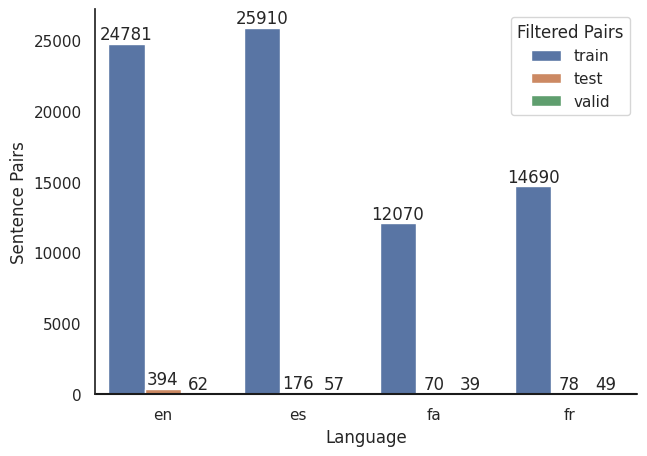

In [17]:
f2, ax2 = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x="lang", y="instances", hue="split", data=df_instances, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.bar_label(ax2.containers[0], fmt='%1.f')
ax2.bar_label(ax2.containers[1], fmt='%1.f')
ax2.bar_label(ax2.containers[2], fmt='%1.f')
ax2.set(xlabel="Language", ylabel="Sentence Pairs")
plt.legend(title="Filtered Pairs", loc='upper right')

sns.despine(bottom=True)

f2.figure.savefig("../figures/04-multicochrane-sent-train-test-valid-split.png")

## Alignments

In [18]:
SENTENCE_SPLITTER = {
    "en": lambda x: nltk.sent_tokenize(x, language="english"),
    "es": lambda x: nltk.sent_tokenize(x, language="spanish"),
    "fr": lambda x: nltk.sent_tokenize(x, language="french"),
    "fa": lambda x: hazm.sent_tokenize(x)
}

In [19]:
def get_alignments(df_lang, lang):
    alignments = {"1-1": 0, "1-n": 0, "n-1": 0}
    sent_tokenize = SENTENCE_SPLITTER[lang]
    
    for index, row in df_lang.iterrows():
        src_len = len(sent_tokenize(row["src"]))
        tgt_len = len(sent_tokenize(row["tgt"]))
    
        if src_len == tgt_len:
            alignments["1-1"] += 1
            continue
            
        if src_len < tgt_len:
            alignments["1-n"] += 1
            continue
            
        if src_len > tgt_len:
            alignments["n-1"] += 1

    return alignments

In [20]:
en_alignments = get_alignments(df_en, "en")
es_alignments = get_alignments(df_es, "es")
fa_alignments = get_alignments(df_fa, "fa")
fr_alignments = get_alignments(df_fr, "fr")

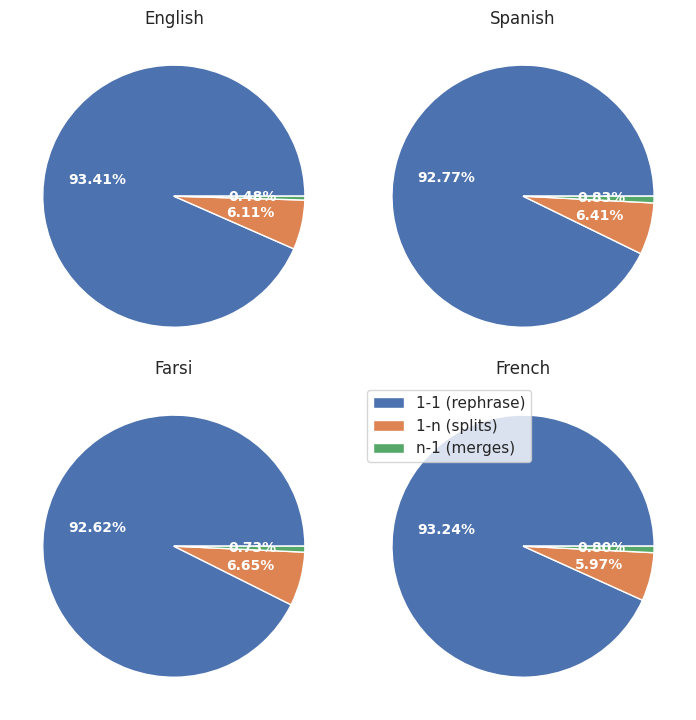

In [33]:
labels = ["1-1 (rephrase)", "1-n (splits)", "n-1 (merges)"]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_autopct

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
_, patches, at1 = ax1.pie(list(en_alignments.values()), autopct=make_autopct([len(df_en.index)]))
_, patches, at2 = ax2.pie(list(es_alignments.values()), autopct=make_autopct([len(df_es.index)]))
_, patches, at3 = ax3.pie(list(fa_alignments.values()), autopct=make_autopct([len(df_fa.index)]))
_, patches, at4 = ax4.pie(list(fr_alignments.values()), autopct=make_autopct([len(df_fr.index)]))

ax1.set_title("English")
ax2.set_title("Spanish")
ax3.set_title("Farsi")
ax4.set_title("French")

fig.tight_layout(pad=0.0)
plt.legend(labels, loc="upper left")

for text in [at1, at2, at3, at4]:
    plt.setp(text, size=10, weight="bold", color="white")

plt.show()
fig.savefig("../figures/04-multiCochrane-alignments.png", bbox_inches="tight")

# Sentence Length

In [23]:
def get_sents_data(df_lang, lang):
    sents_data = {"value": ["min", "max", "avg", "min", "max", "avg"], "sents_count": [], "origin": ["src", "src", "src", "tgt", "tgt", "tgt"]}
    src_sents_len = []
    tgt_sents_len = []
    sent_tokenize = SENTENCE_SPLITTER[lang]
    
    for index, row in df_lang.iterrows():
        src_len = len(sent_tokenize(row["src"]))
        tgt_len = len(sent_tokenize(row["tgt"]))
    
        src_sents_len.append(src_len)
        tgt_sents_len.append(tgt_len)
    
    sents_data["sents_count"].append(min(src_sents_len))
    sents_data["sents_count"].append(max(src_sents_len))
    sents_data["sents_count"].append(round(mean(src_sents_len), 2))
    
    sents_data["sents_count"].append(min(tgt_sents_len))
    sents_data["sents_count"].append(max(tgt_sents_len))
    sents_data["sents_count"].append(round(mean(tgt_sents_len), 2))
    
    return pd.DataFrame(data=sents_data)

In [24]:
en_sents = get_sents_data(df_en, "en")
es_sents = get_sents_data(df_es, "es")
fa_sents = get_sents_data(df_fa, "fa")
fr_sents = get_sents_data(df_fr, "fr")

In [38]:
def create_sent_chart(df_lang, title):
    # Sentence length English
    g1 = sns.catplot(
        data=df_lang,
        kind="bar",
        x="origin",
        y="sents_count",
        hue="value",
        errorbar="sd",
        height=5,
        aspect=2,
    )
    g1.despine(left=True)
    g1.set_axis_labels("Source or target sentences", "Sentence length")
    g1.legend.set_title("Count Type")
    
    ax = g1.facet_axis(0, 0)
    ax.set_title(title)
    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

    g1.savefig(f"../figures/04-multicochrane-sentence-length-{title}.png", bbox_inches="tight")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


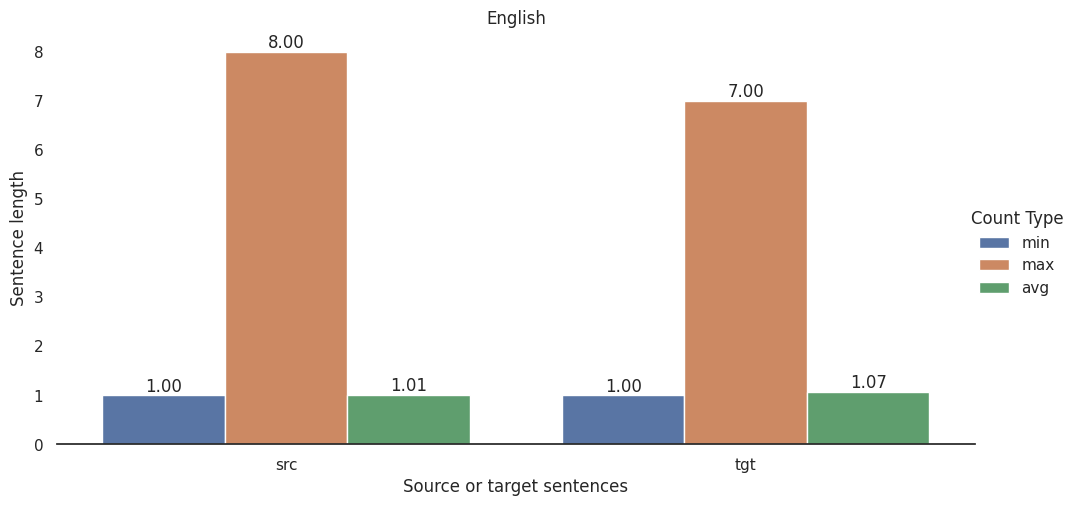

In [39]:
create_sent_chart(en_sents, "English")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


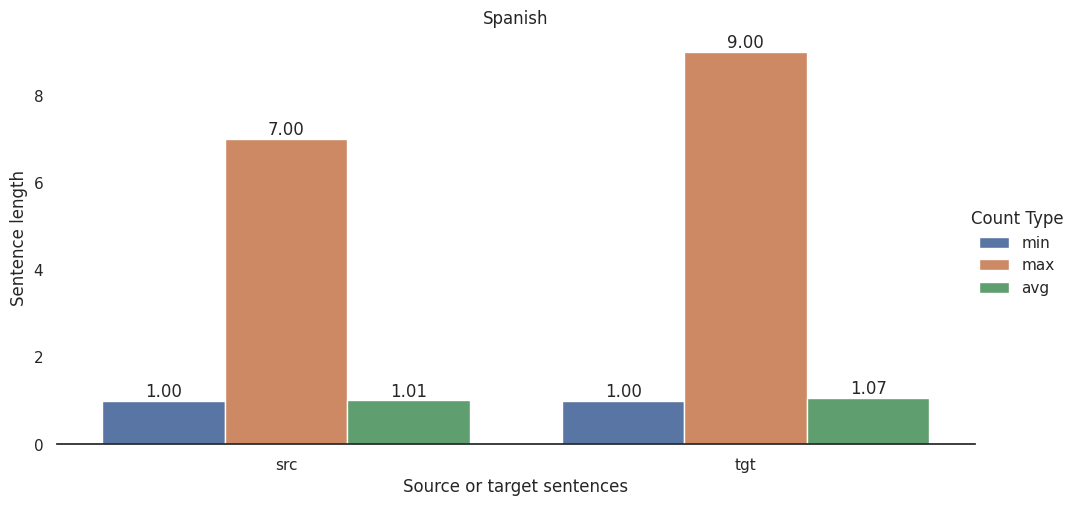

In [40]:
create_sent_chart(es_sents, "Spanish")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


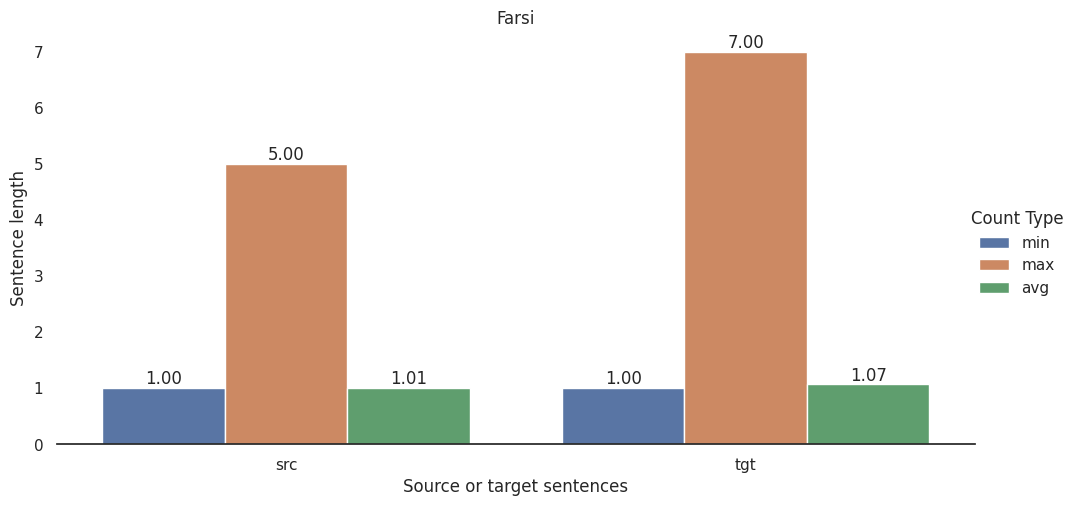

In [41]:
create_sent_chart(fa_sents, "Farsi")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


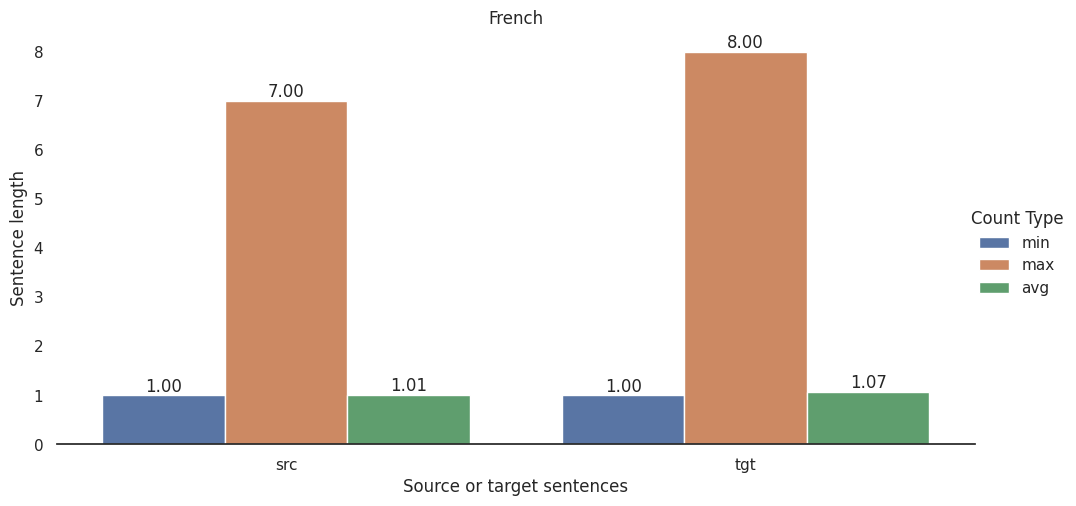

In [42]:
create_sent_chart(fr_sents, "French")

# Token Length

In [28]:
TOKEN_SPLITTER = {
    "en": lambda x: nltk.word_tokenize(x, language="english"),
    "es": lambda x: nltk.word_tokenize(x, language="spanish"),
    "fr": lambda x: nltk.word_tokenize(x, language="french"),
    "fa": lambda x: hazm.word_tokenize(x)
}

In [29]:
def get_token_df(df_lang, lang):
    token_data = {"value": ["min", "max", "avg", "min", "max", "avg"], "count": [], "origin": ["src", "src", "src", "tgt", "tgt", "tgt"]}
    src_token_len = []
    tgt_token_len = []
    word_tokenize = TOKEN_SPLITTER[lang]
    
    for index, row in df_lang.iterrows():
        src_len = len(word_tokenize(row["src"]))
        tgt_len = len(word_tokenize(row["tgt"]))
    
        src_token_len.append(src_len)
        tgt_token_len.append(tgt_len)
    
    token_data["count"].append(min(src_token_len))
    token_data["count"].append(max(src_token_len))
    token_data["count"].append(round(mean(src_token_len), 2))
    
    token_data["count"].append(min(tgt_token_len))
    token_data["count"].append(max(tgt_token_len))
    token_data["count"].append(round(mean(tgt_token_len), 2))
    
    return pd.DataFrame(data=token_data)

In [30]:
en_tokens = get_token_df(df_en, "en")
es_tokens = get_token_df(df_es, "es")
fa_tokens = get_token_df(df_fa, "fa")
fr_tokens = get_token_df(df_fr, "fr")

In [31]:
def create_token_chart(df_lang, title):
    # Token length
    g5 = sns.catplot(
        data=df_lang,
        kind="bar",
        x="origin",
        y="count",
        hue="value",
        errorbar="sd",
        height=5,
        aspect=2,
    )
    g5.despine(left=True)
    g5.set_axis_labels("Source or target tokens", "Token count")
    g5.legend.set_title("Count Type")
    
    ax5 = g5.facet_axis(0, 0)
    ax5.set_title(title)
    
    for p in ax5.patches:
        ax5.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

    g5.savefig(f"../figures/04-multicochrane-token-length-{title}.png", bbox_inches="tight")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


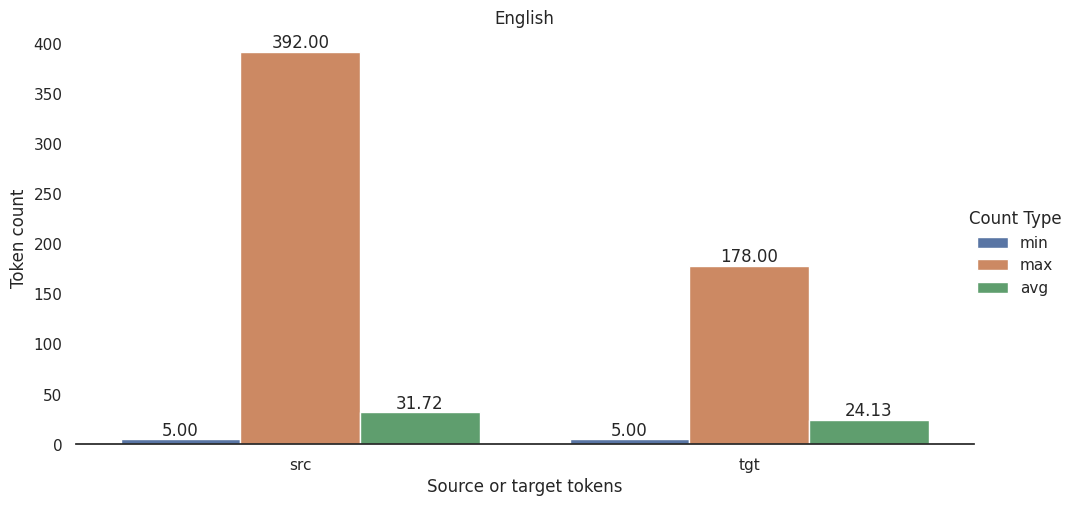

In [43]:
create_token_chart(en_tokens, "English")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


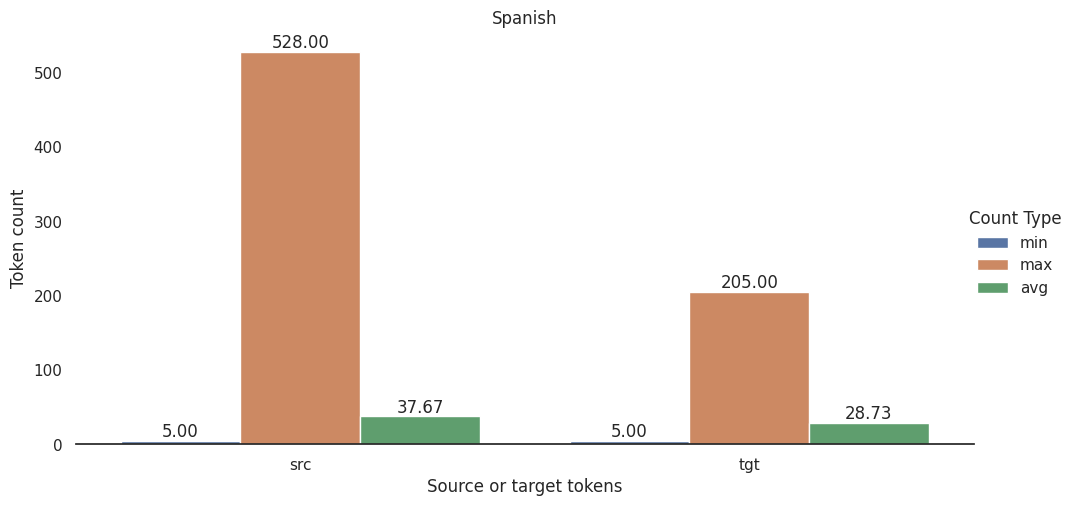

In [44]:
create_token_chart(es_tokens, "Spanish")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


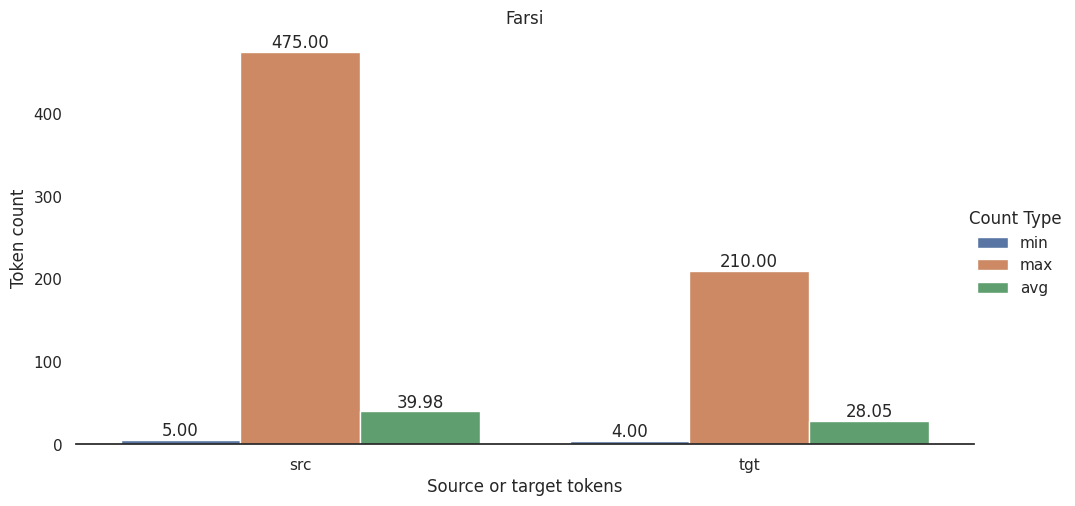

In [45]:
create_token_chart(fa_tokens, "Farsi")

/home/julez/anaconda3/envs/data-description/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


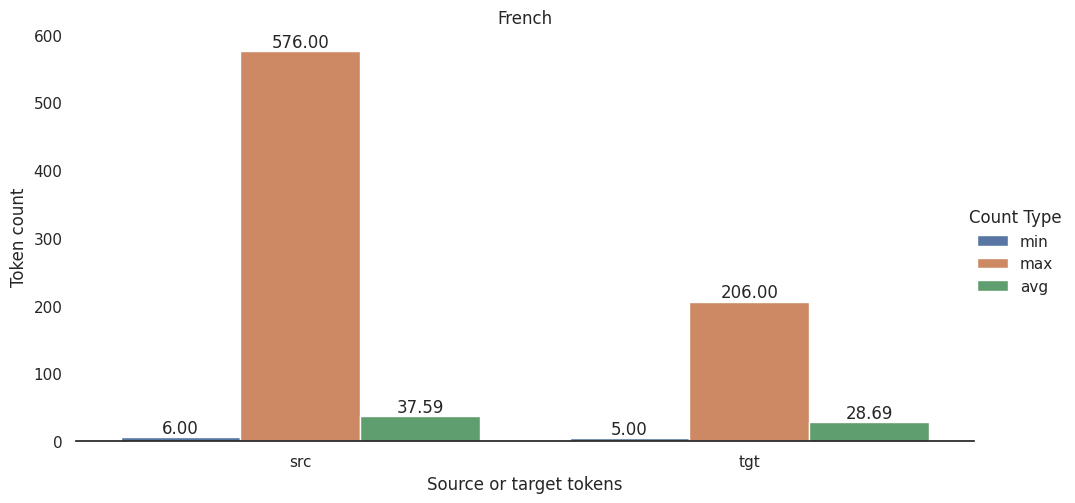

In [46]:
create_token_chart(fr_tokens, "French")

# Novelty

In [47]:
def get_novelty(df_lang, lang):
    percentages = []
    word_tokenize = TOKEN_SPLITTER[lang]
    
    for index, row in df_lang.iterrows():
        tgt_token = word_tokenize(row["tgt"])
        src_token = word_tokenize(row["src"])
    
        tgt_token = set([x.lower() for x in tgt_token])
        src_token = set([x.lower() for x in src_token])
    
        diff = tgt_token.difference(src_token)
        percentages.append(len(diff) / len(tgt_token))
    
    return round(mean(percentages) * 100, 2)

In [48]:
novelty = {"lang": [], "novelty": []}
for lang, frame in data_languages.items():
    novelty["lang"].append(lang)
    novelty["novelty"].append(get_novelty(frame, lang))

df_novelty = pd.DataFrame(novelty)

In [49]:
df_novelty

,lang,novelty
0,en,34.14
1,es,35.75
2,fa,36.58
3,fr,39.61


# FKGL

In [54]:
data_fkgl = {
    "lang": [],
    "origin": [],
    "fkgl": []
}
for lang, frame in data_languages.items():
    data_fkgl["lang"].append(lang)
    data_fkgl["lang"].append(lang)
    data_fkgl["origin"].append("src")
    data_fkgl["origin"].append("tgt")
    data_fkgl["fkgl"].append(corpus_fkgl(frame["src"]))
    data_fkgl["fkgl"].append(corpus_fkgl(frame["tgt"]))

df_fkgl = pd.DataFrame(data=data_fkgl)

In [55]:
df_fkgl

,lang,origin,fkgl
0,en,src,14.641707
1,en,tgt,12.303375
2,es,src,18.831845
3,es,tgt,16.614679
4,fa,src,0.000000
5,fa,tgt,0.000000
6,fr,src,14.787080
7,fr,tgt,12.217052
